<a href="https://colab.research.google.com/github/nahbos/AUT-DIP/blob/main/HW02/Q5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### - Sobhan Moradian Daghigh
#### - 5/7/2022
#### - DIP - HW02 - Q5

In [16]:
import numpy as np
import glob
import cv2
from scipy.ndimage.filters import convolve
from numba import jit
from tqdm import trange
from matplotlib import pyplot as plt

# from imageio import imread, imwrite

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
def load_datas(folder_name):
    images = glob.glob('{}*.png'.format(folder_name))
    datas = []
    names = []
    for image in images:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        datas.append(img)
        names.append(image.split('/')[-1][:-4])
    return datas, names

In [316]:
images, names = load_datas('./drive/MyDrive/DIP-HW02-P5-datas/P5/')

In [302]:
names

['donald_plays_golf',
 'donald_plays_tennis',
 'trump_queen',
 'trump_putin',
 'trump_putin_mask',
 'trump_queen_mask']

# I. Finding the energy map
* Compute the derivative of the image using Sobel filter


In [25]:
def find_energy_map(img):

  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

  filter_du = np.array([[1.0, 2.0, 1.0],
                        [0.0, 0.0, 0.0],
                        [-1.0, -2.0, -1.0]])
  
  filter_dv = np.array([[1.0, 0.0, -1.0],
                        [2.0, 0.0, -2.0],
                        [1.0, 0.0, -1.0]])

  energy_map = np.add(np.absolute(convolve(img, filter_du)), np.absolute(convolve(img, filter_dv)))

  return energy_map

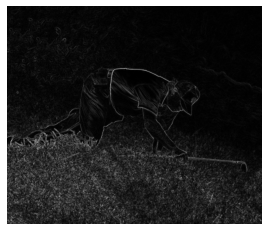

In [304]:
# Test
energy_map = find_energy_map(images[0])
plt.imshow(energy_map, cmap='gray')
plt.axis('off')
plt.show()

# II. Finding the seam with least energy

In [245]:
@jit
def backtracker(energy_map, seam_dir):
  if seam_dir == 'horizontal':
    energy_map = np.rot90(energy_map, 1, (0, 1))

  r, c = energy_map.shape

  M = energy_map.copy()
  backtrack = np.zeros_like(M, dtype=int)

  for i in range(1, r):
      for j in range(0, c):
          if j == 0:
              idx = np.argmin(M[i - 1, j:j + 2])
              backtrack[i, j] = idx + j
              min_energy = M[i - 1, idx + j]
          else:
              idx = np.argmin(M[i - 1, j - 1:j + 2])
              backtrack[i, j] = idx + j - 1
              min_energy = M[i - 1, idx + j - 1]

          M[i, j] += min_energy

  if seam_dir == 'horizontal':
    M = np.rot90(M, 1, (0, 1))
  
  return M, backtrack

In [321]:
@jit
def find_seams_list(energy_map, seam_dir, seam_num): 
  
  r, c = energy_map.shape
  
  seams = []
  for _ in range(seam_num):
    mask = np.ones((r, c))
    M, backtrack = backtracker(energy_map, seam_dir)
    seam = []
    j = np.argmin(M[-1])
    for i in reversed(range(r)):
      seam.append((i, j))
      j = backtrack[i, j]

      mask[i, j] = 0

    energy_map = energy_map[mask==1].reshape((r, c - 1))
    c -= 1    
    seams.append(seam)

  return seams, energy_map

In [279]:
seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='vertical', seam_num=100)

# III. Image resizing

In [313]:
def remove_seams(img, seams_list, seam_dir):
  
  img = img.copy()

  if seam_dir == 'horizontal':
    img = np.rot90(img, 1, (0, 1))

  r, c, _ = img.shape
  org_c = c
  images = []

  for seam in seams_list:
    mask = np.ones((r, c))

    for pixel in seam:
      mask[pixel] = 0

    # To show seams
    img[mask==0] = [255, 0, 0]
    images.append(img)

    # To delete seams
    img = img[mask==1].reshape((r, c - 1, 3))
    c -= 1
    images.append(img)
  
  img = img.reshape((r, org_c - len(seams_list), 3))

  if seam_dir == 'horizontal':
    img = np.rot90(img, 1, (0, 1))

  return img, images

In [288]:
img_resized, frames = remove_seams(img=images[0], seams_list=seams_list, seam_dir='vertical')

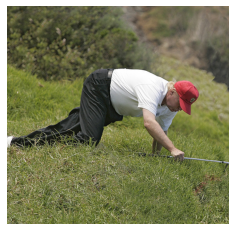

In [289]:
plt.imshow(img_resized)
plt.axis('off')
plt.show()

# Saving as a video to see whats happening

In [378]:
def make_video(frames, name):
  shape = frames[0].shape[1], frames[0].shape[0]
  out = cv2.VideoWriter('./seam_carving_{}.avi'.format(name), cv2.VideoWriter_fourcc(*'DIVX'), 15, shape)
  
  for frame in frames:
    blank = np.zeros(frames[0].shape).astype(np.uint8)
    blank[:, :frame.shape[1]] = frame
    out.write(cv2.cvtColor(blank, cv2.COLOR_RGB2BGR))

  cv2.destroyAllWindows()    
  out.release()

In [394]:
def plotter(energy_map, seams_list, resized_energy_map, resized_img):
  fig, axes = plt.subplots(1, 4, figsize=(17, 5))

  energy_map_color = energy_map.copy().astype(np.uint8)
  _, energy_map_color = cv2.threshold(energy_map_color, 180, 255, cv2.THRESH_BINARY)
  energy_map_color = np.stack([energy_map_color] * 3, axis=2)

  for seam in seams_list:
    for pixel in seam: 
      energy_map_color[pixel] = [255, 0, 0]

  axes[0].imshow(energy_map, cmap='gray')
  axes[0].axis('off')

  axes[1].imshow(energy_map_color)
  axes[1].axis('off')

  axes[2].imshow(resized_energy_map, cmap='gray')
  axes[2].axis('off')

  axes[3].imshow(resized_img)
  axes[3].axis('off')

  plt.show()

# Part A.


In [398]:
percentages = [0.1, 0.25, 0.5]



Width reduction by 10%



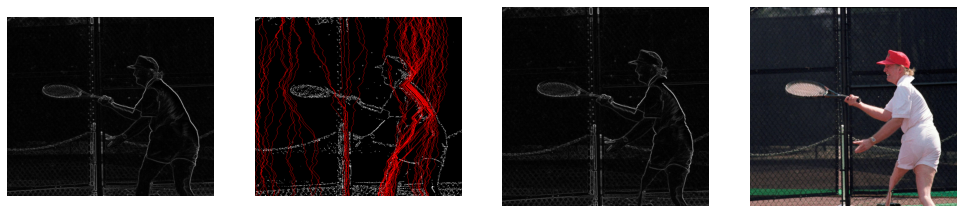



Width reduction by 25%



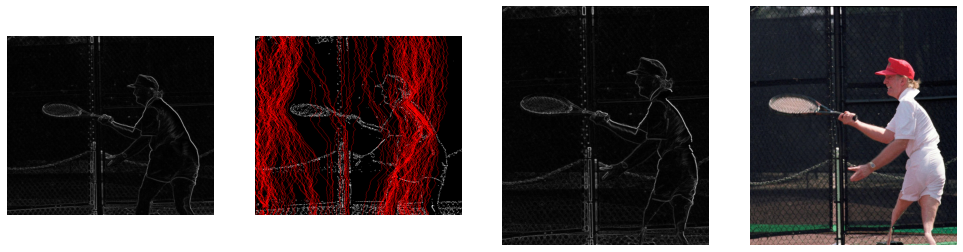



Width reduction by 50%



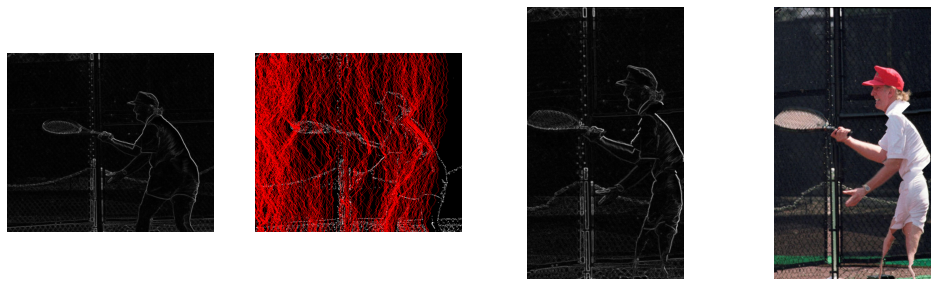

In [400]:
for perc in percentages:
  print('\n\nWidth reduction by {}%\n'.format(int(perc * 100)))
  img = images[1]
  energy_map = find_energy_map(img)
  seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='vertical', seam_num=int(img.shape[1] * perc))
  img_resized, frames = remove_seams(img=img, seams_list=seams_list, seam_dir='vertical')
  plotter(energy_map, seams_list, resized_energy_map, img_resized)
  make_video(frames, name=names[1] + '_' + str(perc))

In [401]:
for perc in percentages:
  print('\n\nWidth reduction by {}%\n'.format(int(perc * 100)))
  img = images[0]
  energy_map = find_energy_map(img)
  seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='horizontal', seam_num=int(img.shape[1] * perc))
  img_resized, frames = remove_seams(img=img, seams_list=seams_list, seam_dir='horizontal')
  plotter(energy_map, seams_list, resized_energy_map, img_resized)
  make_video(frames, name=names[0] + '_' + str(perc))



Width reduction by 10%



ValueError: ignored

# Part B.